In [ ]:
from google.colab import files

# This will open a file chooser to upload your downloaded file
uploaded = files.upload()


KeyboardInterrupt: 

In [ ]:

!ls /content/

sample_data


In [ ]:
import pandas as pd
import requests
import re

def read_pandora_L2_from_url(url):
    resp = requests.get(url)
    resp.raise_for_status()
    lines = resp.text.splitlines()

    # --- Step 1: Extract column names ---
    col_names = []
    for line in lines:
        if line.startswith("Column"):
            m = re.match(r"Column\s+\d+:\s+(.*)", line.strip())
            if m:
                name = m.group(1)
                name = re.sub(r"\[.*?\]", "", name)   # remove [units]
                name = re.sub(r"[^0-9a-zA-Z_ ]+", "", name)  # clean
                name = "_".join(name.lower().split())
                col_names.append(name)

    # --- Step 2: Find where numeric data starts ---
    data_start = None
    dash_count = 0
    for i, line in enumerate(lines):
        if re.match(r"^-{5,}", line):
            dash_count += 1
            if dash_count == 2:  # the second dashed line
                data_start = i + 1
                break
    if data_start is None:
        raise ValueError("Could not find data start")

    # --- Step 3: Collect only numeric lines ---
    data_lines = [l.strip() for l in lines[data_start:] if l.strip() and not l.startswith("Column")]

    # --- Step 4: Build dataframe ---
    df = pd.DataFrame([re.split(r"\s+", l) for l in data_lines])

    # --- Step 5: Assign names if count matches ---
    if len(col_names) == df.shape[1]:
        df.columns = col_names
    else:
        print(f"⚠️ Mismatch: {len(col_names)} names vs {df.shape[1]} columns in data")
        df.columns = [f"col_{i+1}" for i in range(df.shape[1])]

    # --- Step 6: Try parsing first column as datetime ---
    first_col = df.columns[0]
    df[first_col] = pd.to_datetime(df[first_col], errors="coerce")

    return df


# ✅ Usage
url = "https://data.hetzner.pandonia-global-network.org/WashingtonDC/Pandora140s1/L2/Pandora140s1_WashingtonDC_L2_rnvs3p1-8.txt"
df = read_pandora_L2_from_url(url)
print(df.shape)
print(df.head())


(930064, 54)
  ut_date_and_time_for_measurement_center_yyyymmddthhmmssz_iso_8601  \
0                   2020-08-06 15:41:10.600000+00:00                  
1                   2020-08-06 15:43:18.100000+00:00                  
2                   2020-08-06 15:45:28.600000+00:00                  
3                   2020-08-06 15:50:34.900000+00:00                  
4                   2020-08-06 15:52:23.500000+00:00                  

  fractional_days_since_1jan2000_ut_midnight_for_measurement_center  \
0                                        7523.653595                  
1                                        7523.655071                  
2                                        7523.656580                  
3                                        7523.660126                  
4                                        7523.661384                  

  effective_duration_of_measurement solar_zenith_angle_for_measurement_center  \
0                              7.30                 

/tmp/ipython-input-695254985.py:49: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[first_col] = pd.to_datetime(df[first_col], errors="coerce")


In [ ]:
# 1️⃣ See all columns in the DataFrame
print(df.columns)

# Select and rename columns
required_columns = {
    'ut_date_and_time_for_measurement_center_yyyymmddthhmmssz_iso_8601': 'timestamp',
    'nitrogen_dioxide_total_vertical_column_amount_9e99retrieval_not_successful': 'NO2_column_density'
}

# Check if required columns exist in the DataFrame
existing_columns = [col for col in required_columns.keys() if col in df.columns]

if len(existing_columns) == len(required_columns):
    # Select only the required columns and rename them
    df = df[existing_columns].rename(columns=required_columns)
    print("\nSelected and renamed columns:")
    print(df.columns)
else:
    print("\n⚠️ Warning: Not all required columns were found in the DataFrame.")
    print("Required columns:", list(required_columns.keys()))
    print("Existing columns:", existing_columns)


# 2️⃣ Convert the timestamp column to datetime
if 'timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    print("\nTimestamp column converted to datetime.")
else:
    print("\n⚠️ Warning: 'timestamp' column not found after selection and renaming.")

Index(['ut_date_and_time_for_measurement_center_yyyymmddthhmmssz_iso_8601',
       'fractional_days_since_1jan2000_ut_midnight_for_measurement_center',
       'effective_duration_of_measurement',
       'solar_zenith_angle_for_measurement_center',
       'solar_azimuth_for_measurement_center_0north_increases_clockwise',
       'lunar_zenith_angle_for_measurement_center',
       'lunar_azimuth_for_measurement_center_0north_increases_clockwise',
       'rms_of_unweighted_fitting_residuals_9fitting_not_successful',
       'normalized_rms_of_fitting_residuals_weighted_with_independent_uncertainty_9fitting_not_successful_or_no_uncertainty_given',
       'expected_rms_of_unweighted_fitting_residuals_based_on_independent_uncertainty_9fitting_not_successful_or_no_uncertainty_given',
       'expected_normalized_rms_of_weighted_fitting_residuals_based_on_independent_uncertainty_9fitting_not_successful_or_no_uncertainty_given',
       'climatological_station_pressure', 'data_processing_type_index

In [ ]:
import pandas as pd
import re

def read_pandora_L2(file_path):
    """
    Robust reader for Pandora L2 .txt files.
    - Extracts column names from 'Column N: ...' lines
    - Skips metadata/header before the dashed line
    - Reads the table into a DataFrame with proper dtypes
    """

    # Step 1: Read file
    with open(file_path, "r", encoding="latin1") as f:
        lines = f.readlines()

    # Step 2: Extract column definitions
    col_names = []
    for line in lines:
        if line.startswith("Column"):
            # Example: "Column 1: UT date and time ..."
            match = re.match(r"Column\s+\d+:\s+(.*)", line.strip())
            if match:
                col_name = match.group(1)
                # Simplify the column name (remove units/special chars)
                col_name = re.sub(r"\[.*?\]", "", col_name)   # remove [units]
                col_name = re.sub(r"[^0-9a-zA-Z_ ]+", "", col_name) # keep clean
                col_name = "_".join(col_name.lower().split())
                col_names.append(col_name)

    # Step 3: Find where the actual data starts (after dashed line)
    data_start_idx = None
    for i, line in enumerate(lines):
        if re.match(r"^-{5,}", line):  # line of dashes
            data_start_idx = i + 1
            break

    if data_start_idx is None:
        raise ValueError("Could not find start of data table.")

    # Step 4: Extract only data lines
    data_lines = [line.strip() for line in lines[data_start_idx:] if line.strip()]

    # Step 5: Read into DataFrame (whitespace-delimited)
    df = pd.DataFrame([re.split(r"\s+", l) for l in data_lines], columns=col_names)

    # Step 6: Convert numeric columns
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="ignore")

    # Step 7: Handle Timestamp column (assume first column is datetime)
    if "ut_date_and_time_for_measurement_center_yyyymmddthhmmssz_iso_8601" in df.columns:
        ts_col = "ut_date_and_time_for_measurement_center_yyyymmddthhmmssz_iso_8601"
        df[ts_col] = pd.to_datetime(df[ts_col], errors="coerce")
        df = df.set_index(ts_col).sort_index()

    # Step 8: Clean sentinel values
    df = df.replace([-9999, -999, -99], pd.NA)
    df = df.dropna(how="all")
    df = df.drop_duplicates()

    return df


# ✅ Use your actual file path
file_path = "/content/Pandora140s1_WashingtonDC_L2_rnvs3p1-8.txt"
df = read_pandora_L2(file_path)

# Quick check
print(df.head())
print(df.columns[:10])  # show first 10 column names

FileNotFoundError: [Errno 2] No such file or directory: '/content/Pandora140s1_WashingtonDC_L2_rnvs3p1-8.txt'

In [ ]:
# Check dataframe shape and column types
print(df.shape)
print(df.info())

# Quick look at first few rows
display(df.head())

(930064, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 930064 entries, 0 to 930063
Data columns (total 2 columns):
 #   Column              Non-Null Count   Dtype              
---  ------              --------------   -----              
 0   timestamp           930064 non-null  datetime64[ns, UTC]
 1   NO2_column_density  930064 non-null  object             
dtypes: datetime64[ns, UTC](1), object(1)
memory usage: 14.2+ MB
None


,timestamp,NO2_column_density
0,2020-08-06 15:41:10.600000+00:00,1.2436e-04
1,2020-08-06 15:43:18.100000+00:00,1.2665e-04
2,2020-08-06 15:45:28.600000+00:00,2.4551e-04
3,2020-08-06 15:50:34.900000+00:00,1.5051e-04
4,2020-08-06 15:52:23.500000+00:00,1.2749e-04


In [ ]:
# Count missing values
print(df.isna().sum())

# Drop rows where NO2 or Time is missing
df = df.dropna(subset=['timestamp', 'NO2_column_density'])

# Optional: reset index
df.reset_index(drop=True, inplace=True)

timestamp             0
NO2_column_density    0
dtype: int64


In [ ]:
# Remove spaces, make lowercase
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
print(df.columns)


Index(['timestamp', 'no2_column_density'], dtype='object')


In [ ]:
# Keep only relevant columns
df = df[['timestamp', 'no2_column_density']]

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# Check the result
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 930064 entries, 0 to 930063
Data columns (total 2 columns):
 #   Column              Non-Null Count   Dtype              
---  ------              --------------   -----              
 0   timestamp           930064 non-null  datetime64[ns, UTC]
 1   no2_column_density  930064 non-null  object             
dtypes: datetime64[ns, UTC](1), object(1)
memory usage: 14.2+ MB
None
                         timestamp no2_column_density
0 2020-08-06 15:41:10.600000+00:00         1.2436e-04
1 2020-08-06 15:43:18.100000+00:00         1.2665e-04
2 2020-08-06 15:45:28.600000+00:00         2.4551e-04
3 2020-08-06 15:50:34.900000+00:00         1.5051e-04
4 2020-08-06 15:52:23.500000+00:00         1.2749e-04


In [ ]:
df = df.drop_duplicates()


In [ ]:
# Remove unrealistic NO2 values (negative or extremely high)
df = df[(df['no2_column_density'] > 0) & (df['no2_column_density'] < 1e5)]  # adjust upper limit if needed


TypeError: '>' not supported between instances of 'str' and 'int'

In [ ]:
print(df['timestamp'].min(), df['timestamp'].max())


2020-08-06 15:41:10.600000+00:00 2025-09-28 22:39:34.900000+00:00


In [ ]:
print(df['no2_column_density'].describe())


count         930064
unique         65605
top       1.2439e-04
freq             152
Name: no2_column_density, dtype: object


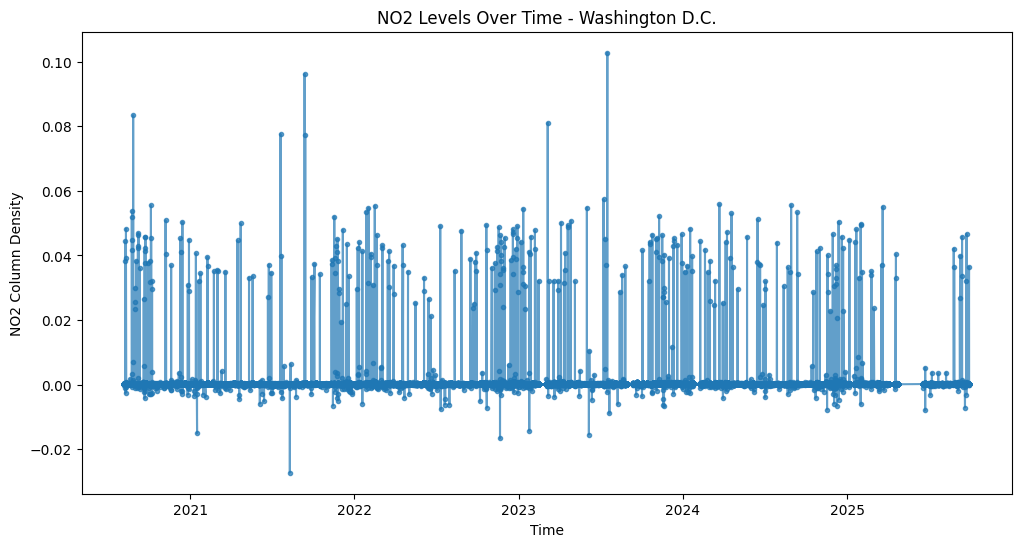

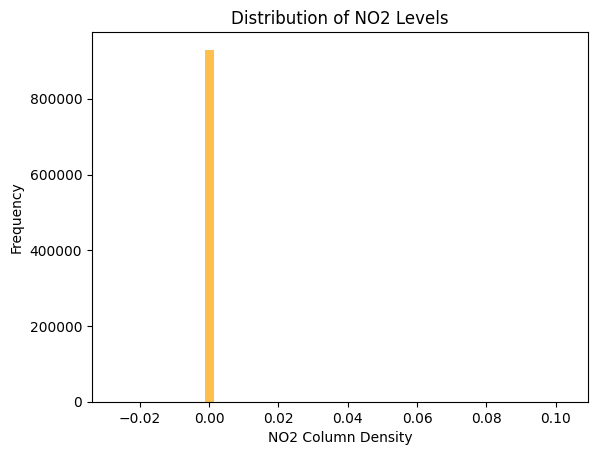

In [ ]:
import matplotlib.pyplot as plt

# Convert 'no2_column_density' to numeric, coercing errors
df['no2_column_density'] = pd.to_numeric(df['no2_column_density'], errors='coerce')

# Drop rows where conversion failed
df = df.dropna(subset=['no2_column_density'])

# Time series plot
plt.figure(figsize=(12,6))
plt.plot(df['timestamp'], df['no2_column_density'], marker='.', linestyle='-', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('NO2 Column Density')
plt.title('NO2 Levels Over Time - Washington D.C.')
plt.show()

# Histogram of NO2 values
plt.hist(df['no2_column_density'], bins=50, alpha=0.7, color='orange')
plt.xlabel('NO2 Column Density')
plt.ylabel('Frequency')
plt.title('Distribution of NO2 Levels')
plt.show()

In [ ]:
# Simple IQR method
Q1 = df['no2_column_density'].quantile(0.25)
Q3 = df['no2_column_density'].quantile(0.75)
IQR = Q3 - Q1

outliers = df[(df['no2_column_density'] < Q1 - 1.5*IQR) | (df['no2_column_density'] > Q3 + 1.5*IQR)]
print(f"Number of outliers: {len(outliers)}")


Number of outliers: 56787


In [ ]:
!pip install nbimporter


In [ ]:
!pwd
!ls


/content
sample_data


In [ ]:
# List all variables in memory
%whos DataFrame


Variable   Type         Data/Info
---------------------------------
df         DataFrame                             <...>[930064 rows x 2 columns]
outliers   DataFrame                             <...>n[56787 rows x 2 columns]


In [ ]:
# Example: check first few rows
print(df.head())           # if df exists
print(df_pandora.head())   # if df_pandora exists
print(pandora_df.head())   # if pandora_df exists


                         timestamp  no2_column_density
0 2020-08-06 15:41:10.600000+00:00            0.000124
1 2020-08-06 15:43:18.100000+00:00            0.000127
2 2020-08-06 15:45:28.600000+00:00            0.000246
3 2020-08-06 15:50:34.900000+00:00            0.000151
4 2020-08-06 15:52:23.500000+00:00            0.000127


NameError: name 'df_pandora' is not defined

In [ ]:
output_file = "pandora_NO2.csv"
df.to_csv(output_file, index=False)
print(f"✅ File saved as {output_file}")


✅ File saved as pandora_NO2.csv


In [ ]:
from google.colab import files
files.download(output_file)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>